# Spotify ReWrapped

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import pylast
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

import time
import datetime
import re
from itertools import groupby, count
from collections import OrderedDict
import requests
from io import BytesIO

from IPython.display import clear_output, HTML
from PIL import Image
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

Let's log into Last.fm and retrieve the tracks until the 1st of December, when Wrapped was released.

### Last.fm

In [11]:
from config import LASTFM_API_KEY, LASTFM_SHARED_SECRET, LASTFM_PASSWORD

In [12]:
# In order to perform a write operation you need to authenticate yourself
username = "alexing10"
password_hash = pylast.md5(LASTFM_PASSWORD)

network = pylast.LastFMNetwork(api_key=LASTFM_API_KEY, api_secret=LASTFM_SHARED_SECRET,
                               username=username, password_hash=password_hash)
user = network.get_authenticated_user()

In [4]:
d = datetime.date(2018,1,1)

unixtime = time.mktime(d.timetuple())
tracks = user.get_recent_tracks(limit=None, time_from=unixtime)

In [5]:
first_elem = tracks[0]
print(type(first_elem), len(tracks))

<class 'pylast.PlayedTrack'> 14812


In [6]:
def print_track(a_track):
    print(".artist: ", a_track.track.artist)
    album = str(a_track.track.get_album())
    if not album:
        album = ''
    print(".get_album(): ", re.sub(r"^[^-]*- ", "", album))
    print(".get_duration(): ",a_track.track.get_duration())
    print(".get_listener_count(): ",a_track.track.get_listener_count())
    print(".get_mbid(): ",a_track.track.get_mbid())
    print(".get_playcount(): ",a_track.track.get_playcount())
    print(".get_url(): ",a_track.track.get_url())
    print(".info: ",a_track.track.info)
    print(".title: ",a_track.track.title)

print_track(first_elem)

.artist:  Marilina Bertoldi
.get_album():  Prender un Fuego
.get_duration():  188000
.get_listener_count():  227
.get_mbid():  None
.get_playcount():  1351
.get_url():  https://www.last.fm/music/marilina%2bbertoldi/_/nunca
.info:  {}
.title:  Nunca


In [7]:
print_track(tracks[568])

.artist:  Riff
.get_album():  None
.get_duration():  0
.get_listener_count():  31
.get_mbid():  None
.get_playcount():  46
.get_url():  https://www.last.fm/music/riff/_/sube%2ba%2bmi%2bvoiture%2b-%2ben%2bvivo
.info:  {}
.title:  Sube a Mi Voiture - En Vivo


Let's try to scrape a little more data from each track

In [17]:
def get_data(a_track):
    data = []
    data.append(str(a_track.track.artist))
    data.append(a_track.track.title)
    try:
        album = str(a_track.track.get_album())
        if not album:
            album = ''
    except:
        album = ''
    data.append(re.sub(r"^[^-]*- ", "", album))
    try:
        duration = a_track.track.get_duration()
    except:
        duration = ''
    data.append(duration)
    try:
        listener_count = a_track.track.get_listener_count()
    except:
        listener_count = ''
    data.append(listener_count)
    try:
        mbid = a_track.track.get_mbid()
    except:
        mbid = ''
    data.append(mbid)
    try:
        playcount = a_track.track.get_playcount()
    except:
        playcount = ''
    data.append(playcount)
    try:
        url = a_track.track.get_url()
    except:
        url = ''
    data.append(url)
    data.append(a_track.track.info)
    data.append(a_track.playback_date)
    data.append(a_track.timestamp)
    return data

In [18]:
data = {}
amount_of_tracks = len(tracks)
for i, a_track in enumerate(tracks):
    data[i] = get_data(a_track)
    print("Got data from %d/%d tracks" % (i+1, amount_of_tracks))
    clear_output(wait=True)

Got data from 14812/14812 tracks


In [19]:
df = pd.DataFrame.from_dict(data, orient='index')
df.columns=['artist', 'title', 'album', 'duration', 'listener_count', 'mbid', 'playcount', 'url', 'info', 'date', 'timestamp']
df.head()

,artist,title,album,duration,listener_count,mbid,playcount,url,info,date,timestamp
0,Marilina Bertoldi,Nunca,Prender un Fuego,188000,228,None,1366,https://www.last.fm/music/marilina%2bbertoldi/...,{},"08 Dec 2018, 19:43",1544298210
1,Marilina Bertoldi,La Casa de A,None,0,243,None,1688,https://www.last.fm/music/marilina%2bbertoldi/...,{},"08 Dec 2018, 19:40",1544298014
2,Marilina Bertoldi,Fumar de día,Prender un Fuego,178000,350,None,2149,https://www.last.fm/music/marilina%2bbertoldi/...,{},"08 Dec 2018, 19:37",1544297834
3,Marilina Bertoldi,O No?,Prender un Fuego,181000,242,None,1343,https://www.last.fm/music/marilina%2bbertoldi/...,{},"08 Dec 2018, 19:34",1544297653
4,The 1975,Inside Your Mind,ネット上の人間関係についての簡単な調査 [Explicit],230000,20179,None,63956,https://www.last.fm/music/the%2b1975/_/inside%...,{},"08 Dec 2018, 18:59",1544295551


In [20]:
# df.to_csv("data/data.csv")

It looks nice. Let's repair a little bit.

In [44]:
df['track'] = None
for i, a_track in enumerate(tracks):
    if df.at[i, 'timestamp'] == a_track.timestamp:
        df.at[i, 'track'] = a_track

In [47]:
df['track'].isnull().sum()

0

In [85]:
amount_of_tracks = len(df)
for i, row in df.iterrows():
    try:
        if row['album'] == 'None':
            album = str(row['track'].track.get_album())
            df.at[i, 'album'] = re.sub(r"^[^-]*- ", "", album)
        if row['duration'] == 0:
            df.at[i, 'duration'] = row['track'].track.get_duration()
        if row['listener_count'] == '':
            df.at[i, 'listener_count'] = row['track'].track.get_listener_count()
        if row['mbid'] == None:
            df.at[i, 'mbid'] = row['track'].track.get_mbid()           
        if row['playcount'] == '':
            df.at[i, 'playcount'] = row['track'].track.get_playcount()           
    except:
        continue
    print("Tried to repair data from %d/%d tracks" % (i+1, amount_of_tracks))
    clear_output(wait=True)
print("Amount of 'None' albums left: %d" % ((df.album == 'None').sum()))
print("Amount of 0 duration left: %d" % ((df.duration == 0).sum()))
print("Amount of '' listener_count left: %d" % ((df.listener_count == '').sum()))
print("Amount of '' playcount left: %d" % ((df.playcount == '').sum()))


Amount of 'None' albums left: 2604
Amount of 0 duration left: 2598
Amount of '' listener_count left: 3
Amount of '' playcount left: 3


Didn't work. Maybe query spotify?

### Spotify

Use first result of search

In [572]:
from config import SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET, SPOTIFY_USER

client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID,
                                                      client_secret=SPOTIFY_CLIENT_SECRET)
scope = 'user-top-read'
token = util.prompt_for_user_token(SPOTIFY_USER, scope, client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET, redirect_uri="http://localhost:8888/")
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, auth=token)


In [570]:
errors = []
amount_of_tracks = len(df)
for i, row in df.iterrows():
    if row['album'] == 'None' or row['duration'] == 0:
        try:
            results = sp.search(q=u' '.join([row['artist'], row['title']]), type='track', market='AR')
        except:
            continue
        if len(results['tracks']['items']) == 0:
            if row['artist'] == 'Sandman Project' and row['title'] == 'Circies':
                row['title'] = df.at[i, 'title'] = 'Circles'
                
            query = re.sub(r'\s-.*$','',u' '.join([row['artist'], row['title']]))
            results = sp.search(q=query, type='track', market='AR')
            print(results)
            print(' '.join([row['artist'], row['title']]))
        try:
            if row['album'] == 'None':
                df.at[i, 'album'] = results['tracks']['items'][0]['album']['name']
            if row['duration'] == 0:
                df.at[i, 'duration'] = results['tracks']['items'][0]['duration_ms']      
        except:
            errors.append((i, row))
            continue
            
    print("Tried to repair data from %d/%d tracks" % (i+1, amount_of_tracks))
    clear_output(wait=True)
print("Amount of 'None' albums left: %d" % ((df.album == 'None').sum()))
print("Amount of 0 duration left: %d" % ((df.duration == 0).sum()))
print("Problems:")
for an_error in errors:
    print("Detected error in index: %d with %s - %s" % (an_error[0], an_error[1]['artist'], an_error[1]['title']))

Tried to repair data from 4866/14812 tracks


Manually fixing at last

In [185]:
df.at[7500, 'album'] = 'SplitLife'               # with Gilad Hekselman - Suite For Sweets
df.at[8124, 'album'] = 'Lamp Lit Prose'             # with Dirty Projectors - (I Wanna) Feel It All (feat. Dear Nora)
df.at[8125, 'album'] = 'Lamp Lit Prose'             #  with Dirty Projectors - You're The One (feat. Robin Pecknold & Rostam)
df.at[8129, 'album'] = 'Lamp Lit Prose'             #  with Dirty Projectors - Zombie Conqueror (feat. Empress Of)
df.at[8130, 'album'] = 'Lamp Lit Prose'             #  with Dirty Projectors - I Feel Energy (feat. Amber Mark)
df.at[8133, 'album'] = 'Lamp Lit Prose'             #  with Dirty Projectors - Right Now (feat. Syd)
df.at[8166, 'album'] = 'Lamp Lit Prose'             #  with Dirty Projectors - Right Now (feat. Syd)
df.at[8756, 'album'] = 'The Life Aquatic Studio Sessions'             # with Seu Jorge - O Astronauta De Mármore - Starman
df.at[9207, 'album'] = "Rock 'N' Roll"            #  with John Lennon - Medley: Rip It Up/Ready Teddy - 2010 - Remaster
df.at[9373, 'album'] = 'Unplugged (The Official Bootleg)'       #        with Paul McCartney - Ain't No Sunshine - Live On MTV Unplugged
df.at[9377, 'album'] = 'Unplugged (The Official Bootleg)'       #        with Paul McCartney - Hi-Heel Sneakers - Live On MTV Unplugged
df.at[9378, 'album'] = 'Unplugged (The Official Bootleg)'       #        with Paul McCartney - She's a Woman - Live On MTV Unplugged
df.at[9381, 'album'] = 'Unplugged (The Official Bootleg)'       #       with Paul McCartney - San Francisco Bay Blues - Live On MTV Unplugged
df.at[9383, 'album'] = 'Unplugged (The Official Bootleg)'       #       with Paul McCartney - Blue Moon of Kentucky - Live On MTV Unplugged
df.at[9385, 'album'] = 'Unplugged (The Official Bootleg)'       #        with Paul McCartney - I Lost My Little Girl - Live On MTV Unplugged
df.at[9386, 'album'] = 'Unplugged (The Official Bootleg)'       #        with Paul McCartney - Be-Bop-A-Lula - Live On MTV Unplugged
df.at[9424, 'album'] = 'Wings Over America'      #         with Paul McCartney - Venus And Mars / Rock Show / Jet - 2013 Remaster
df.at[10187, 'album'] = ''       #       with Static & Ben El - Otw
df.at[10396, 'album'] = 'Jardín'        #      with Gabriel Garzón-Montano - Bombo Fabrica
df.at[10583, 'album'] = 'Leyli'         #     with Leyli - Nishbati Lachzor Elecha
df.at[10584, 'album'] = 'Leyli'         #     with Leyli - Holchim Al Ze
df.at[10585, 'album'] = 'Leyli'         #     with Leyli - Hi
df.at[10586, 'album'] = 'Leyli'         #     with Leyli - Ze Kvar Nikar
df.at[10587, 'album'] = 'Leyli'         #     with Leyli - Rak Shetikach Oti Ita
df.at[10588, 'album'] = 'Leyli'         #    with Leyli - Naki Umeluchlach
df.at[10589, 'album'] = 'Leyli'         #     with Leyli - Tzafona
df.at[10590, 'album'] = 'Leyli'         #     with Leyli - Sham Me'ever Lapsanter
df.at[10591, 'album'] = 'Leyli'         #    with Leyli - BeYamim
df.at[11346, 'album'] = 'SplitLife'     #         with Gilad Hekselman - Suite For Sweets
df.at[12072, 'album'] = 'SplitLife'     #         with Gilad Hekselman - Suite For Sweets
df.at[12088, 'album'] = 'SplitLife'     #         with Gilad Hekselman - When Will The Blues Leave
df.at[12089, 'album'] = 'SplitLife'     #        with Gilad Hekselman - Suite For Sweets
df.at[12092, 'album'] = 'SplitLife'     #        with Gilad Hekselman - Hello Who Is It?

mean = int(np.round(np.mean(df[df['duration'] != '']['duration'])))
for i in [x[0] for x in errors]:
    df.at[i, 'duration'] = mean

In [186]:
print("Amount of 'None' albums left: %d" % ((df.album == 'None').sum()))
print("Amount of 0 duration left: %d" % ((df.duration == 0).sum()))

Amount of 'None' albums left: 12
Amount of 0 duration left: 5


In [202]:
df[df.album == 'None'].index

Int64Index([ 9020, 11197, 11460, 11461, 11838, 11866, 12236, 12237, 12455,
            12540, 12819, 13641],
           dtype='int64')

In [203]:
df.at[9020, 'album'] = '22, A Million'
df.at[11197, 'album'] = 'Band On The Run'
df.at[11460, 'album'] = '' 
df.at[11461, 'album'] =  ''
df.at[11838, 'album'] =  'Perdido Dia Gris'
df.at[11866, 'album'] = "Outlandos D'Amour"
df.at[12236, 'album'] = '' 
df.at[12237, 'album'] = '' 
df.at[12455, 'album'] = ''
df.at[12540, 'album'] = '' 
df.at[12819, 'album'] = ''
df.at[13641, 'album'] = 'Sueño Stereo'
for i in df[df.duration == 0].index:
    df.at[i, 'duration'] = mean

In [314]:
for i in df[df.duration == ''].index:
    df.at[i, 'duration'] = mean

In [204]:
print("Amount of 'None' albums left: %d" % ((df.album == 'None').sum()))
print("Amount of 0 duration left: %d" % ((df.duration == 0).sum()))

Amount of 'None' albums left: 0
Amount of 0 duration left: 0


### FINALLY
Let's start the fun

In [205]:
df.head()

,artist,title,album,duration,listener_count,mbid,playcount,url,info,date,timestamp,track
0,Marilina Bertoldi,Nunca,Prender un Fuego,188000,228,None,1366,https://www.last.fm/music/marilina%2bbertoldi/...,{},"08 Dec 2018, 19:43",1544298210,"(Marilina Bertoldi - Nunca, Prender un Fuego, ..."
1,Marilina Bertoldi,La Casa de A,Prender un Fuego,196000,243,None,1688,https://www.last.fm/music/marilina%2bbertoldi/...,{},"08 Dec 2018, 19:40",1544298014,"(Marilina Bertoldi - La Casa de A, Prender un ..."
2,Marilina Bertoldi,Fumar de día,Prender un Fuego,178000,350,None,2149,https://www.last.fm/music/marilina%2bbertoldi/...,{},"08 Dec 2018, 19:37",1544297834,"(Marilina Bertoldi - Fumar de día, Prender un ..."
3,Marilina Bertoldi,O No?,Prender un Fuego,181000,242,None,1343,https://www.last.fm/music/marilina%2bbertoldi/...,{},"08 Dec 2018, 19:34",1544297653,"(Marilina Bertoldi - O No?, Prender un Fuego, ..."
4,The 1975,Inside Your Mind,ネット上の人間関係についての簡単な調査 [Explicit],230000,20179,None,63956,https://www.last.fm/music/the%2b1975/_/inside%...,{},"08 Dec 2018, 18:59",1544295551,"(The 1975 - Inside Your Mind, A Brief Inquiry ..."


In [ ]:
#Let's convert to date
for i, row in df.iterrows():
    df.at[i, 'date'] = datetime.datetime.strptime(row['date'], '%d %b %Y, %H:%M:%S')

In [99]:
#df.to_csv("data/data.csv")

In [6]:
df = pd.read_csv("data/data.csv").drop("Unnamed: 0", axis=1)


## Let's start the analysis

### 1) "Este año, escuchaste 8.486 canciones diferentes en Spotify." <font color='red'>FALSE</font>
(This year you listened to 8486 different song in Spotify)

In [7]:
unique_songs = df.drop_duplicates(subset=['artist', 'title', 'album']).shape[0]
unique_songs

6693

In [8]:
print("There's a difference of %d in the analysis" % (8486 - unique_songs))

There's a difference of 1793 in the analysis


### 2) "You started 2018 by listening to Life Wasted - Brendan O' Brien Mix by Pearl Jam and the first artist you discovered was Faces." <font color='green'>TRUE</font> / <font color='red'>FALSE</font>

In [384]:
df.loc[df['timestamp'].idxmin()]

artist                                                    Pearl Jam
title                             Life Wasted - Brendan O'Brien Mix
album                                          Pearl Jam (2017 Mix)
duration                                                     232186
listener_count                                                  989
mbid                                                            NaN
playcount                                                      1690
url               https://www.last.fm/music/pearl%2bjam/_/life%2...
info                                                             {}
date                                            2018-01-01 11:06:00
timestamp                                                1514804801
track             PlayedTrack(track=pylast.Track('Pearl Jam', "L...
Name: 14811, dtype: object

#### __Indeed the first song is Life Wasted__

How do we consider what is discovered? Let's check the 50 top artists for each term that Last.fm defines, combine them in a set and check what's the first thing to appear outside of the set.

In [385]:
ranges = ['short_term', 'medium_term', 'long_term']
top_artists = set()
for a_range in ranges:
    results = sp.current_user_top_artists(time_range=a_range, limit=50)
    for item in results['items']:
        top_artists.add(item['name'])
    results = sp.current_user_top_artists(time_range=a_range, limit=50, offset=49)
    for item in results['items']:
        top_artists.add(item['name'])
top_artists

{'Acollective',
 'Adrián Berra',
 'Almendra',
 'Alvy, Nacho Y Rubin',
 'Ana Prada',
 'Anderson .Paak',
 'Animals As Leaders',
 'Arcade Fire',
 'Arctic Monkeys',
 'Asaf Avidan',
 'Atoms For Peace',
 'BROCKHAMPTON',
 'Babasónicos',
 'Banda do Mar',
 'Barney Kessel',
 'Beirut',
 'Bersuit Vergarabat',
 'Bill Frisell',
 'Bob Dylan',
 'Bon Iver',
 'Bonobo',
 'Bourbon Sweethearts',
 'Bruno Mars',
 'Bulgara',
 'Café Tacvba',
 'Carlos Gardel',
 'Catupecu Machu',
 'Chance the Rapper',
 'Charly García',
 'Chris Cornell',
 'Coldplay',
 'David Bowie',
 'Death Cab for Cutie',
 'Diego Boneta',
 'Divididos',
 'Dream Theater',
 'Duke Ellington',
 'Ed Sheeran',
 'Edmundo Rivero',
 'El Kuelgue',
 'Ella Fitzgerald',
 'Elliott Smith',
 'Esperanza Spalding',
 'Father John Misty',
 'Fleet Foxes',
 'Frank Ocean',
 'George Ezra',
 'Gilad Hekselman',
 'Glass Animals',
 'Gorillaz',
 'Green Day',
 'Gustavo Cerati',
 'Hinds',
 'Illya Kuryaki & The Valderramas',
 'Izan Llunas',
 'Jack Johnson',
 'Jack White',
 'Jak

In [386]:
reverse_df = df.iloc[::-1]
for i, row in reverse_df.iterrows():
    if row['artist'] not in top_artists:
        print("Song n# %d of the year" % (len(df) - i))
        print(row['artist'])
        print("Played on %s" % str(row['date']))
        break

Song n# 74 of the year
Whitney
Played on 2018-01-01 16:04:00


So, Whitney is the first band I actually discovered.

In [387]:
df[df['artist'] == 'Faces']

,artist,title,album,duration,listener_count,mbid,playcount,url,info,date,timestamp,track


__Last.fm doesn't register one scrobble to my name for Faces.__

In [388]:
artist = pylast.Artist("Radiohead", network, username='alexing10')
print("As a baseline, Radiohead has %d scrobbles." % artist.get_userplaycount())

As a baseline, Radiohead has 1172 scrobbles.


In [389]:
artist = pylast.Artist("Faces", network, username='alexing10')
print("Faces has %d scrobbles." % artist.get_userplaycount())

Faces has 0 scrobbles.


In [390]:
artist = pylast.Artist("Whitney", network, username='alexing10')
print("Whitney has %d scrobbles and %d plays this year" % (artist.get_userplaycount(),len(df[df['artist'] == 'Whitney'])))

Whitney has 13 scrobbles and 12 plays this year


#### __Faces was never reproduced. First discovery is Whitney.__

### 3) "Listened to 58776 minutes." <font color='green'></font>  <font color='red'>FALSE</font>

In [391]:
df.duration.astype('int').sum() / 1000 / 60

60572.71953333333

We have some lead with the tracks regarding date

In [392]:
minutes_total_to_december = df[399:].duration.astype('int').sum() / 1000 / 60
minutes_total_to_december

59057.221783333334

In [393]:
dif = np.abs(58776 - minutes_total_to_december)
minutes, seconds = divmod(dif * 60 , 60)
print("There's a difference of %d minutes and %d seconds" % (minutes, seconds))
amount_of_songs = int(np.round(dif * 60 * 1000 / mean))
print("By mean duration of songs listened to this year, there's and error of %d songs" % amount_of_songs)

There's a difference of 281 minutes and 13 seconds
By mean duration of songs listened to this year, there's and error of 69 songs


### 4) "You spent 41 hours with your favorite artist Jorge Drexler, and the pleasure was all theirs." <font color='green'></font>  <font color='red'>FALSE</font>

In [394]:
top_listened = df[399:].groupby(by=['artist']).agg('sum')['duration'].sort_values(ascending=False)[:10]
top_listened = top_listened / 1000 / 60 / 60 # ms / s / m -> h
top_listened

artist
Jorge Drexler      42.335542
Serú Girán         33.730778
Radiohead          33.452604
Arctic Monkeys     26.142524
Gustavo Cerati     19.803698
Charly García      19.138179
Vampire Weekend    18.478611
Sufjan Stevens     17.274734
Soda Stereo        16.740329
Anderson .Paak     15.226572
Name: duration, dtype: float64

In [395]:
hours, minutes = divmod(top_listened[0] * 60, 60)
print("The real time is %d hours and %d minutes" % (int(hours), int(minutes)))

The real time is 42 hours and 20 minutes


## 5) THE CHARTS
### Top artists: Jorge Drexler, Radiohead, Arctic Monkeys, Vampire Weekend, Gustavo Cerati
### Top songs: Estocolmo, Los días eternos, Cirrus, Black Treacle, Shangai Safari
### Top genres: Rock, Indie, Pop, Latin, Mexican
### Top albums: ??

<font color='green'></font>  <font color='red'>FALSE EVERYWHEREEEE</font>

In [9]:
top_artists = df[399:].groupby(by=['artist']).agg('count')['track'].sort_values(ascending=False)[:10]
top_artists

artist
Jorge Drexler      688
Arctic Monkeys     447
Radiohead          427
Serú Girán         425
Vampire Weekend    321
Charly García      292
Gustavo Cerati     267
Sufjan Stevens     256
Anderson .Paak     235
Soda Stereo        217
Name: track, dtype: int64

Really interesting. Arctic Monkeys and Radiohead are inverted by a difference of 20 songs (acceptable?).
__What up with Serú Girán and Charly García?!__

In [10]:
top_tracks = df[399:].groupby(by=['title', 'artist']).agg('count')['track'].sort_values(ascending=False)[:20]
top_tracks

title                                              artist         
Tints (feat. Kendrick Lamar)                       Anderson .Paak     34
Hannah Hunt                                        Vampire Weekend    31
Unmade                                             Thom Yorke         26
Canción De Alicia En El País - Remastered Version  Serú Girán         26
Black Treacle                                      Arctic Monkeys     24
On the Level                                       Mac DeMarco        24
Tu Amor                                            Charly García      23
Shanghai Safari                                    Martin Oliver      22
Step                                               Vampire Weekend    22
Unbelievers                                        Vampire Weekend    22
Seminare                                           Serú Girán         21
Star Treatment                                     Arctic Monkeys     21
Autos, Jets, Aviones, Barcos                       Serú G

This is even more __MEGA WTF__?!
All the numbers are wrong. Estocolmo (17), Los días eternos (18), Cirrus (not on top 20), Black Treacle(5), Shangai Safari (8)


In [11]:
top_albums = df[399:].groupby(by=['album']).agg('count')['track'].sort_values(ascending=False)[:20]
top_albums

album
Modern Vampires of the City        241
This Old Dog                       182
Suck It and See                    179
Bicicleta                          151
Psicosis Radio                     134
Banda do Mar                       128
Exit Inside (Deluxe Edition)       119
Tranquility Base Hotel + Casino    110
A Pesar de la Era                  108
Amar La Trama                      108
Carrie & Lowell                    106
In Rainbows                        103
Bailar en la Cueva                 102
A Moon Shaped Pool                 100
Marry Me                            93
Cara B                              92
Man of the Woods                    92
Lost in the Dream                   90
alt-J - An Awesome Wave             89
Peperina                            82
Name: track, dtype: int64

Let's look first at what happened with the artists

In [155]:
df_seru = df[df['artist'] == 'Serú Girán'].reset_index()
df_seru = df_seru.set_index(pd.DatetimeIndex(df_seru["date"]))
time_series_seru = df_seru['date'].resample('D').count()

df_charly = df[df['artist'] == 'Charly García'].reset_index()
df_charly = df_charly.set_index(pd.DatetimeIndex(df_charly["date"]))
time_series_charly = df_charly['date'].resample('D').count()

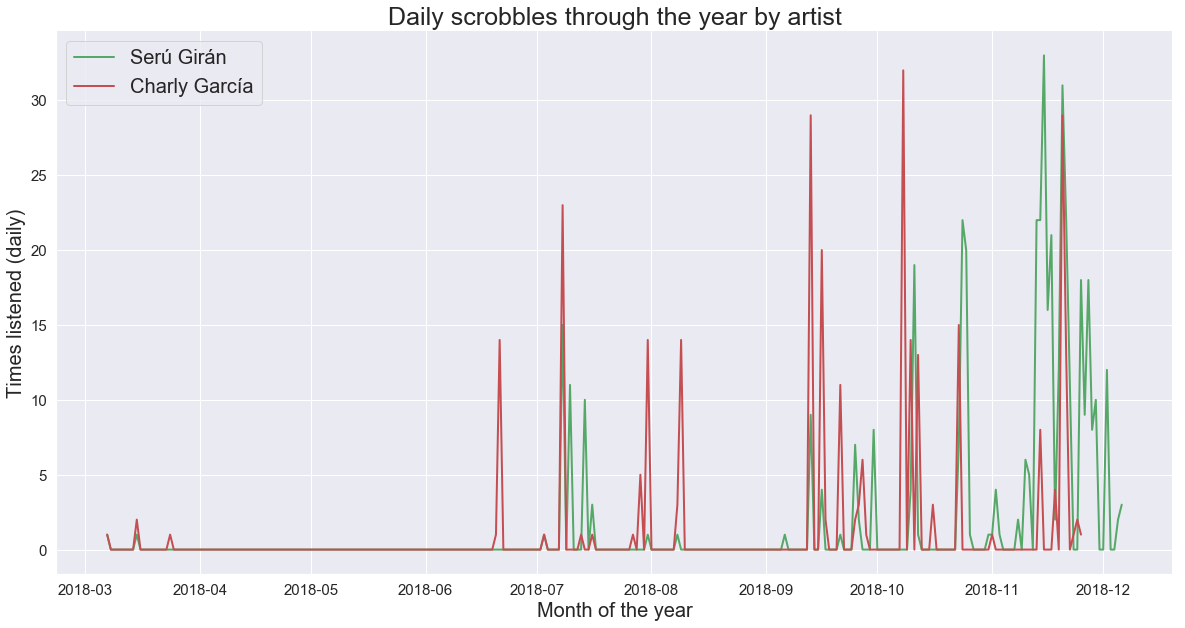

In [156]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x=time_series_seru.index, y=time_series_seru.values, color='g', label='Serú Girán')
ax = sns.lineplot(x=time_series_charly.index, y=time_series_charly.values, color='r', label='Charly García')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.setp(ax.lines,linewidth=2)  # set lw for all lines of g axes
plt.ylabel("Times listened (daily)", fontsize=20)
plt.xlabel('Month of the year', fontsize=20)
plt.title('Daily scrobbles through the year by artist', fontsize=25)
plt.legend(prop={'size': 20}, loc='best')
sns.despine()
plt.show()

So, most of Charly and Serú was listened after September. Interesting. Let's check accumulation

In [161]:
time_series_seru = df_seru['date'].resample('D').count().cumsum()
time_series_charly = df_charly['date'].resample('D').count().cumsum()

# compensate for null days in the end
last_valid = time_series_charly.last_valid_index()
last_in_seru = time_series_seru.last_valid_index()
annex = pd.Series({date: time_series_charly.loc[last_valid] for date in pd.date_range(last_valid, last_in_seru)})
time_series_charly = time_series_charly.append(annex)

In [164]:
def add_pic(path, xy, ax):
    arr_img = plt.imread(path, format='png')
    imagebox = OffsetImage(arr_img, zoom=0.2)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy,
                        xybox=(120., -80.),
                        xycoords='data',
                        boxcoords="offset points",
                        pad=0.5,
                        frameon=False,
                        )
    ax.add_artist(ab)

/Users/alex/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


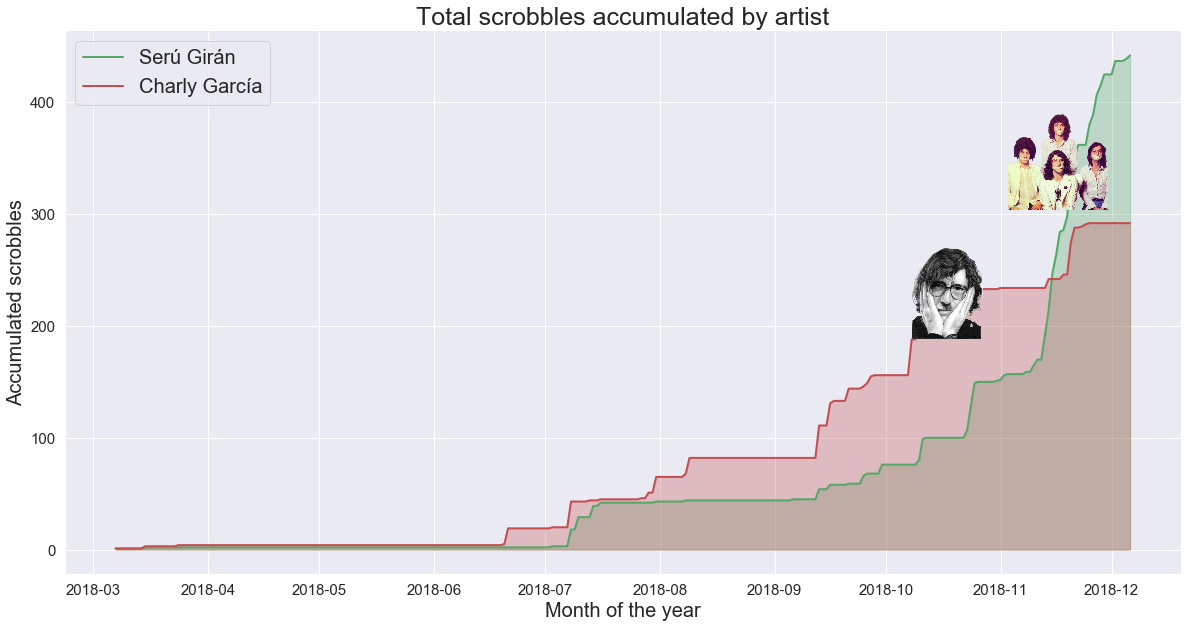

In [165]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x=time_series_seru.index, y=time_series_seru.values, color='g', label='Serú Girán')
ax = sns.lineplot(x=time_series_charly.index, y=time_series_charly.values, color='r', label='Charly García')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.setp(ax.lines,linewidth=2)  # set lw for all lines of g axes

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="g", alpha=0.3)
ax.fill_between(x2,y2, color="r", alpha=0.3)

#Charly's pic
add_pic('img/charly.png', ('2018-09-15', 300), ax)
#Seru's pic
add_pic('img/seru.png', ('2018-10-15', 420), ax)

plt.ylabel("Accumulated scrobbles", fontsize=20)
plt.xlabel('Month of the year', fontsize=20)
plt.title('Total scrobbles accumulated by artist', fontsize=25)
plt.legend(prop={'size': 20}, loc='best')
sns.despine()
plt.show()

This is just what we need. Let's do it for the top artists.

In [166]:
artists = top_artists.index[:7]
time_series = {}
for an_artist in artists:
    a_df = df[df['artist'] == an_artist].reset_index()
    a_df['date'] = pd.to_datetime(a_df['date'])
    a_df = a_df.set_index(a_df["date"])
    time_series[an_artist] = a_df['date'].resample('D').count().cumsum()

In [167]:
colormap = {
    'Jorge Drexler': 'xkcd:tan', 
    'Arctic Monkeys': 'xkcd:aqua', 
    'Radiohead': 'xkcd:pale yellow', 
    'Serú Girán': 'g',
    'Vampire Weekend': 'xkcd:lavender', 
    'Charly García': 'r', 
    'Gustavo Cerati': 'xkcd:grey blue'
}

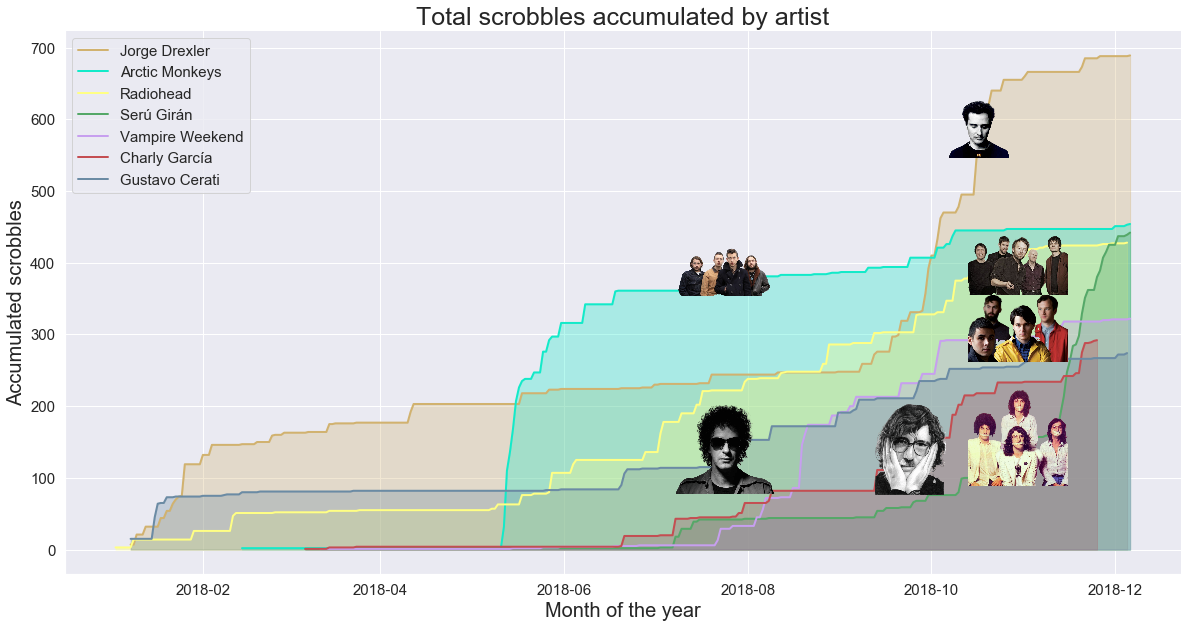

In [168]:
fig, ax = plt.subplots(figsize=(20,10))
for an_artist in artists:
     ax = sns.lineplot(x=time_series[an_artist].index, 
                       y=time_series[an_artist].values, 
                       label=an_artist, 
                       color=colormap[an_artist])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.setp(ax.lines,linewidth=2)  # set lw for all lines of g axes

# Get the xy data from the lines so that we can shade
for a_line in ax.lines:
    x = a_line.get_xydata()[:,0]
    y = a_line.get_xydata()[:,1]
    ax.fill_between(x, y, alpha=0.3, color=colormap[a_line.get_label()])
    
#pics
add_pic('img/charly.png', ('2018-08-15', 250), ax)
add_pic('img/seru.png', ('2018-09-20', 270), ax)
add_pic('img/radiohead.png', ('2018-09-20', 510), ax)
add_pic('img/vampire.png', ('2018-09-20', 420), ax)
add_pic('img/cerati.png', ('2018-06-15', 250), ax)
add_pic('img/arctic.png', ('2018-06-15', 500), ax)
add_pic('img/drexler.png', ('2018-09-07', 700), ax)

plt.ylabel("Accumulated scrobbles", fontsize=20)
plt.xlabel('Month of the year', fontsize=20)
plt.title('Total scrobbles accumulated by artist', fontsize=25)
    
plt.legend(prop={'size': 15})
sns.despine()
plt.show()

This is crazy interesting! It almost proves Spoti started being lazy with where they cut the year.

Let's do some cleaning

In [169]:
df_artists = pd.concat(time_series, axis=1)
df_artists = df_artists.replace(0,np.nan).apply(lambda x: x.loc[:x.last_valid_index()].fillna(0)).ffill()

Spotify's top artists: Jorge Drexler, Radiohead, Arctic Monkeys, Vampire Weekend, Gustavo Cerati

This order never happens.

In [170]:
for i, row in df_artists.iterrows():
    # Spotify's top artists: Jorge Drexler, Radiohead, Arctic Monkeys, Vampire Weekend, Gustavo Cerati
    if (row['Jorge Drexler'] > row['Radiohead']) and\
        (row['Radiohead'] > row['Arctic Monkeys']) and\
        (row['Arctic Monkeys'] > row['Vampire Weekend']) and\
        (row['Vampire Weekend'] > row['Gustavo Cerati']) and\
        ((row['Gustavo Cerati'] > row['Serú Girán']) or (row['Gustavo Cerati'] > row['Charly García'])):
            print(i)

Let's disregard the order

In [171]:
spotify_dates = []
for i, row in df_artists.iterrows():
    # Spotify's top artists: Jorge Drexler, Radiohead, Arctic Monkeys, Vampire Weekend, Gustavo Cerati
    if  ((row['Jorge Drexler'] > row['Serú Girán']) and (row['Jorge Drexler'] > row['Charly García'])) and\
        ((row['Radiohead'] > row['Serú Girán']) and (row['Radiohead'] > row['Charly García'])) and\
        ((row['Arctic Monkeys'] > row['Serú Girán']) and (row['Arctic Monkeys'] > row['Charly García'])) and\
        ((row['Vampire Weekend'] > row['Serú Girán']) and (row['Vampire Weekend'] > row['Charly García'])) and\
        ((row['Gustavo Cerati'] > row['Serú Girán']) and (row['Gustavo Cerati'] > row['Charly García'])):
            spotify_dates.append(i)

In [172]:
def as_range(iterable): # not sure how to do this part elegantly
    l = list(iterable)
    if len(l) > 1:
        return l[0], l[-1]
    else:
        return l[0], None

The possible ranges are between 2018-06-18 00:00:00 and 2018-06-19 00:00:00
The possible ranges are between 2018-08-07 00:00:00 and 2018-08-08 00:00:00
The possible ranges are between 2018-08-16 00:00:00 and 2018-11-16 00:00:00


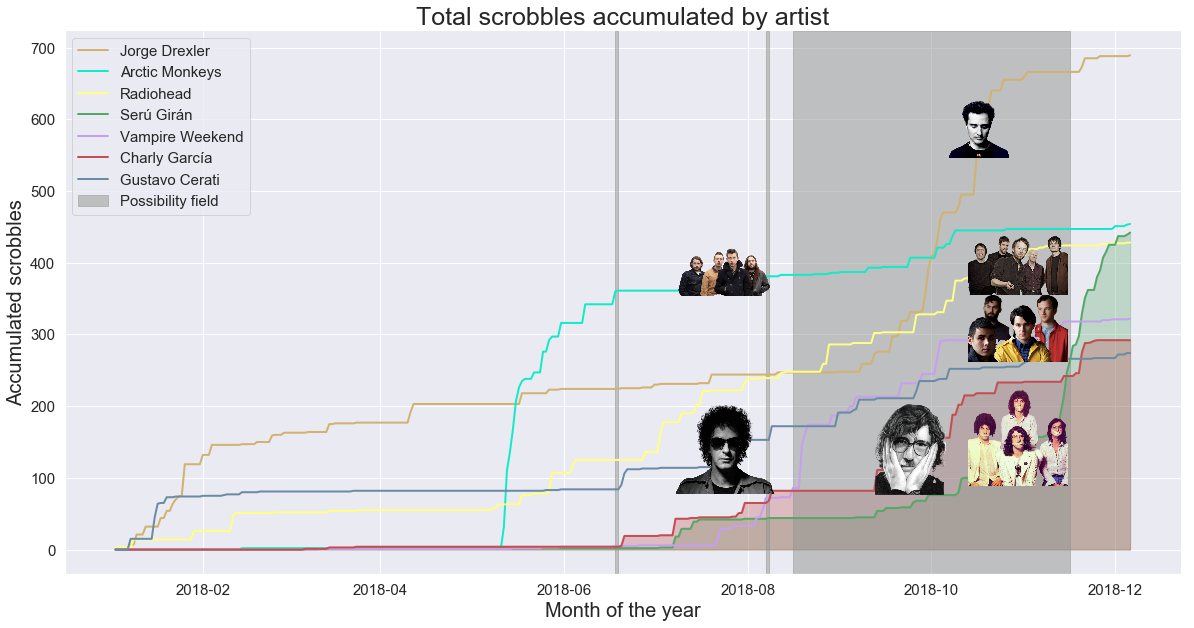

In [173]:
# to add images later
# https://stackoverflow.com/questions/3765056/combine-picture-and-plot-with-python-matplotlib
fig, ax = plt.subplots(figsize=(20,10))
for an_artist in artists:
     ax = sns.lineplot(x=df_artists[an_artist].index, 
                       y=df_artists[an_artist].values, 
                       label=an_artist, 
                       color=colormap[an_artist])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.setp(ax.lines,linewidth=2)  # set lw for all lines of g axes

# Get the xy data from the lines so that we can shade
for a_line in ax.lines:
    artist = a_line.get_label()
    if artist == 'Charly García' or artist == 'Serú Girán':
        x = a_line.get_xydata()[:,0]
        y = a_line.get_xydata()[:,1]
        ax.fill_between(x, y, alpha=0.3, color=colormap[artist])
    
#pics
add_pic('img/charly.png', ('2018-08-15', 250), ax)
add_pic('img/seru.png', ('2018-09-20', 270), ax)
add_pic('img/radiohead.png', ('2018-09-20', 510), ax)
add_pic('img/vampire.png', ('2018-09-20', 420), ax)
add_pic('img/cerati.png', ('2018-06-15', 250), ax)
add_pic('img/arctic.png', ('2018-06-15', 500), ax)
add_pic('img/drexler.png', ('2018-09-07', 700), ax)

for _, j in groupby(spotify_dates, lambda n, c=count(): n-next(c)):
    x0, x1 = as_range(j)
    ax.axvspan(x0, x1, color='xkcd:grey', alpha=0.5, label='Possibility field')
    print("The possible ranges are between %s and %s" %(str(x0), str(x1)))

plt.ylabel("Accumulated scrobbles", fontsize=20)
plt.xlabel('Month of the year', fontsize=20)
plt.title('Total scrobbles accumulated by artist', fontsize=25)    
    
#delete duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 15}, loc='best')

sns.despine()
plt.show()

Now for the songs

In [174]:
tracks = top_tracks.index
time_series = {}
for a_title, an_artist in tracks:
    a_df = df[(df['title'] == a_title) & (df['artist'] == an_artist)].reset_index()
    a_df['date'] = pd.to_datetime(a_df['date'])
    a_df = a_df.set_index(a_df["date"])
    time_series[a_title] = a_df['date'].resample('D').count().cumsum()
    
# Let's add Cirrus    
a_df = df[(df['title'] == 'Cirrus') & (df['artist'] == 'Bonobo')].reset_index()
a_df['date'] = pd.to_datetime(a_df['date'])
a_df = a_df.set_index(a_df["date"])
time_series['Cirrus'] = a_df['date'].resample('D').count().cumsum()

In [175]:
df_songs = pd.concat(time_series, axis=1)
df_songs = df_songs.replace(0,np.nan).apply(lambda x: x.loc[:x.last_valid_index()].fillna(0)).ffill()

In [180]:
def add_annotation(text, xy, ax):
    # Annotate the 1st position with a text box ('Test 1')
    offsetbox = TextArea(text, minimumdescent=False)

    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(-20, 40),
                        xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)

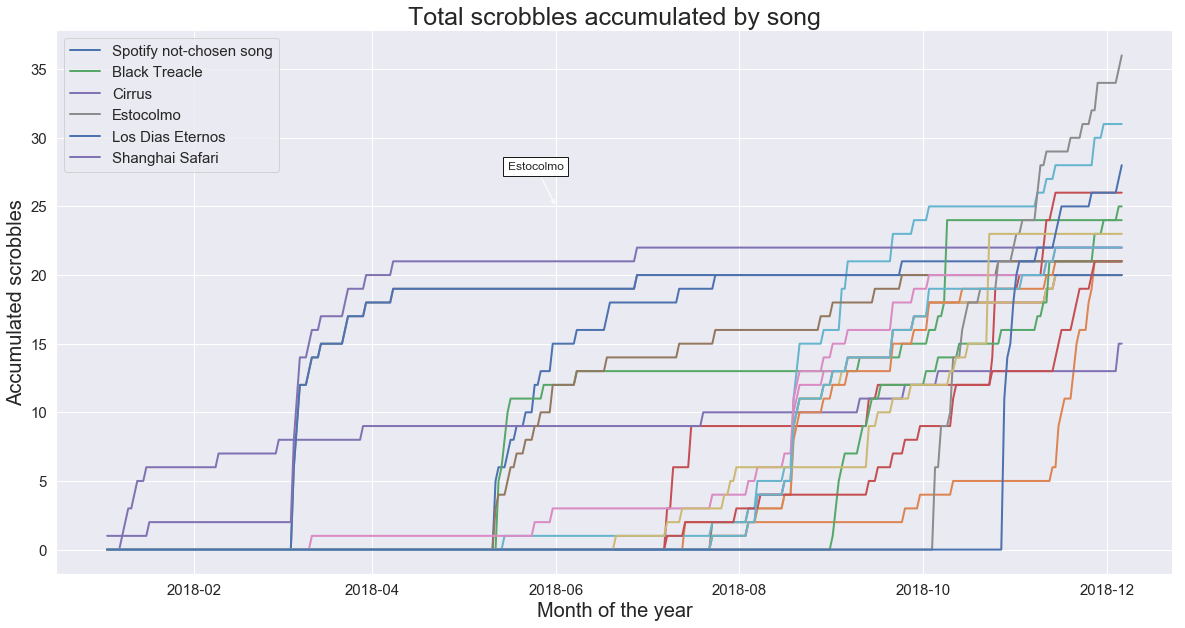

In [185]:
spotify_top = {'Estocolmo', 'Los Dias Eternos', 'Cirrus', 'Black Treacle', 'Shanghai Safari'}

fig, ax = plt.subplots(figsize=(20,10))
for a_title in df_songs.columns:
    if a_title in spotify_top:
        #color = (1,0,0, 0.7)
        label = a_title # 'Spotify chosen song'
        ax = sns.lineplot(x=df_songs[a_title].index, y=df_songs[a_title].values, label=label)#, color=color)
    else:
        color = (0,0,0,0.3)
        label = 'Spotify not-chosen song'
        ax = sns.lineplot(x=df_songs[a_title].index, y=df_songs[a_title].values, label=label, color=color)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.setp(ax.lines,linewidth=2)  # set lw for all lines of g axes

plt.ylabel("Accumulated scrobbles", fontsize=20)
plt.xlabel('Month of the year', fontsize=20)
plt.title('Total scrobbles accumulated by song', fontsize=25)    

#delete duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), prop={'size': 15}, loc='best')

add_annotation('Estocolmo', ('2018-06', 25), ax)

sns.despine()
plt.show()    

In [448]:
spotify_dates = []
for i, row in df_songs.iterrows():
    if set(row.sort_values(ascending=False)[:5].index) == spotify_top:
        spotify_dates.append(i)

The possible ranges are between 2018-05-14 00:00:00 and 2018-05-21 00:00:00


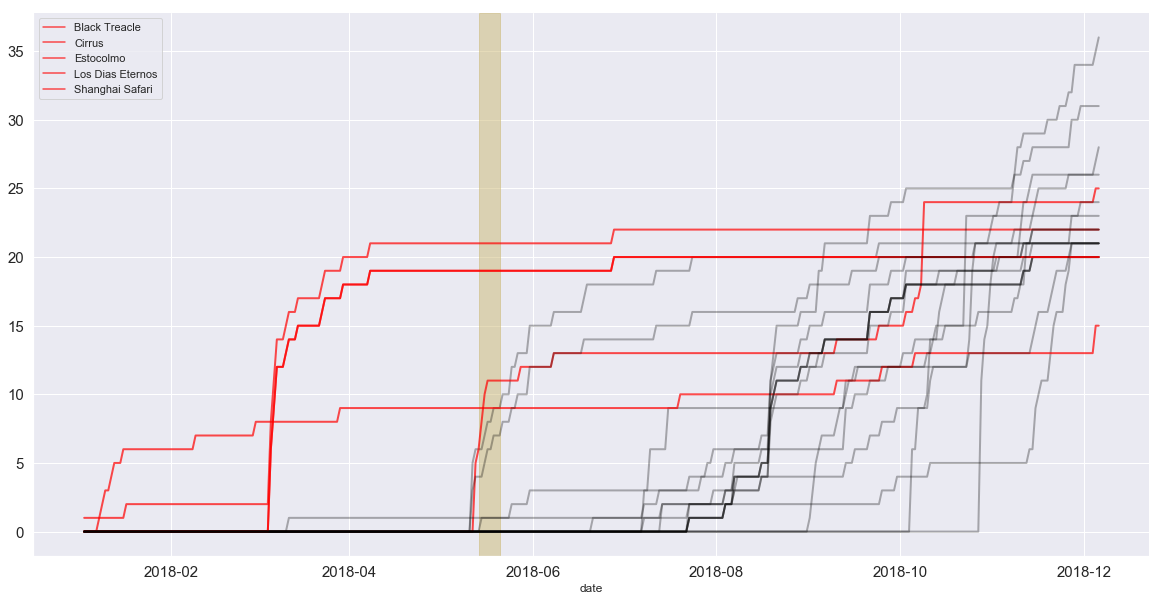

In [449]:
# to add images later
# https://stackoverflow.com/questions/3765056/combine-picture-and-plot-with-python-matplotlib

spotify_top = {'Estocolmo', 'Los Dias Eternos', 'Cirrus', 'Black Treacle', 'Shanghai Safari'}

fig, ax = plt.subplots(figsize=(20,10))
for a_title in df_songs.columns:
    if a_title in spotify_top:
        color = (1,0,0, 0.7)
        label = a_title
    else:
        color = (0,0,0,0.3)
        label = None
    ax = sns.lineplot(x=df_songs[a_title].index, y=df_songs[a_title].values, label=label, color=color)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.setp(ax.lines,linewidth=2)  # set lw for all lines of g axes

for _, j in groupby(spotify_dates, lambda n, c=count(): n-next(c)):
    x0, x1 = as_range(j)
    ax.axvspan(x0, x1, color='y', alpha=0.5)
    print("The possible ranges are between %s and %s" %(str(x0), str(x1)))
    
sns.despine()
plt.show()    

Too narrow. Maybe eliminating a song?

In [454]:
spotify_dates_missing_key = {}
for a_song in df_songs.columns:
    if a_song in spotify_top:
        continue
    spotify_dates_missing_key[a_song] = []
    for i, row in df_songs.loc[:,df_songs.columns != a_song].iterrows():
        if set(row.sort_values(ascending=False)[:5].index) == spotify_top:
            spotify_dates_missing_key[a_song].append(i)

The possible ranges are between 2018-05-13 00:00:00 and 2018-05-24 00:00:00 if we take out AMERICAN SPORTS
The possible ranges are between 2018-05-14 00:00:00 and 2018-05-21 00:00:00 if we take out Autos, Jets, Aviones, Barcos
The possible ranges are between 2018-05-14 00:00:00 and 2018-05-21 00:00:00 if we take out Canción De Alicia En El País - Remastered Version
The possible ranges are between 2018-05-14 00:00:00 and 2018-05-21 00:00:00 if we take out Diane Young
The possible ranges are between 2018-05-14 00:00:00 and 2018-05-21 00:00:00 if we take out Don't Lie
The possible ranges are between 2018-05-14 00:00:00 and 2018-05-21 00:00:00 if we take out Everlasting Arms
The possible ranges are between 2018-05-14 00:00:00 and 2018-05-21 00:00:00 if we take out Hannah Hunt
The possible ranges are between 2018-05-15 00:00:00 and 2018-05-18 00:00:00 if we take out Obvious Bicycle
The possible ranges are between 2018-05-15 00:00:00 and 2018-05-18 00:00:00 if we take out On the Level
The po

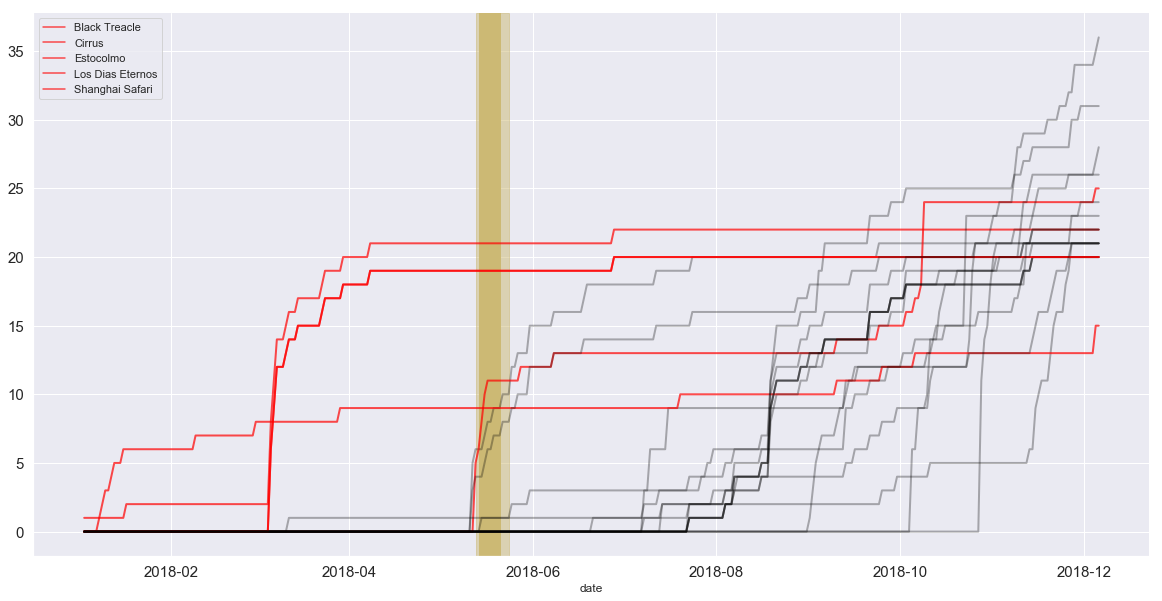

In [457]:
# to add images later
# https://stackoverflow.com/questions/3765056/combine-picture-and-plot-with-python-matplotlib

spotify_top = {'Estocolmo', 'Los Dias Eternos', 'Cirrus', 'Black Treacle', 'Shanghai Safari'}

fig, ax = plt.subplots(figsize=(20,10))
for a_title in df_songs.columns:
    if a_title in spotify_top:
        color = (1,0,0, 0.7)
        label = a_title
    else:
        color = (0,0,0,0.3)
        label = None
    ax = sns.lineplot(x=df_songs[a_title].index, y=df_songs[a_title].values, label=label, color=color)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
plt.setp(ax.lines,linewidth=2)  # set lw for all lines of g axes

for a_song in spotify_dates_missing_key:
    for _, j in groupby(spotify_dates_missing_key[a_song], lambda n, c=count(): n-next(c)):
        x0, x1 = as_range(j)
        ax.axvspan(x0, x1, color='y', alpha=0.5)
        print("The possible ranges are between %s and %s if we take out %s" %(str(x0), str(x1), a_song))
    
sns.despine()
plt.show()    

UNEXPLAINABLE

Let's not go into genre b@llsh!t

Top albums just because

In [470]:
albums = user.get_top_albums(limit=10, period=pylast.PERIOD_12MONTHS)

In [522]:
def path_to_image_html(path):
    return '<img src="'+ path + '" style="max-height:124px;"/>'

In [525]:
columns = ['plays', 'title', "artist", 'cover']
rows = []
for an_album in albums:
    url = an_album.item.get_cover_image()
    rows.append([an_album.weight, an_album.item.title, an_album.item.artist, url])
df_albums = pd.DataFrame(data=rows, columns=columns)
df_albums.at[5, 'cover'] = 'https://f4.bcbits.com/img/a3052774803_10.jpg' # some cheating cause last.fm is missing the cover

In [526]:
pd.set_option('display.max_colwidth', -1)

HTML(df_albums.to_html(escape=False ,formatters=dict(cover=path_to_image_html)))

,plays,title,artist,cover
0,241,Modern Vampires of the City,Vampire Weekend,
1,211,Yo No Quiero Volverme Tan Loco,Serú Girán,
2,182,Suck It and See,Arctic Monkeys,
3,180,Tranquility Base Hotel & Casino,Arctic Monkeys,
4,177,This Old Dog,Mac DeMarco,
5,154,Psicosis Radio,Martin Oliver,
6,150,Malibu,Anderson .Paak,
7,139,Nodyssey,theAngelcy,
8,129,Banda do Mar,Banda do Mar,
9,126,Exit Inside (Deluxe Edition),theAngelcy,


## 6) Top 100

In [531]:
top_tracks = df.groupby(by=['title', 'artist']).agg('count')['track'].sort_values(ascending=False)[:100]
top_tracks

title                                              artist                 
Tints (feat. Kendrick Lamar)                       Anderson .Paak             36
Hannah Hunt                                        Vampire Weekend            31
Unmade                                             Thom Yorke                 28
Canción De Alicia En El País - Remastered Version  Serú Girán                 26
Black Treacle                                      Arctic Monkeys             25
On the Level                                       Mac DeMarco                24
Tu Amor                                            Charly García              23
Step                                               Vampire Weekend            22
Unbelievers                                        Vampire Weekend            22
Shanghai Safari                                    Martin Oliver              22
Star Treatment                                     Arctic Monkeys             21
Thinking                          